In [1]:
# If you already have these, this cell will be quick.
!pip install --quiet tqdm transformers torch torchvision pandas pillow matplotlib

In [1]:
from pathlib import Path
import os, sys, json, math, time, zipfile, glob, re
import requests
from tqdm import tqdm

# Project dirs
DATA_ROOT = Path("data")
COCO_ROOT = DATA_ROOT / "coco"
ANN_DIR   = COCO_ROOT / "annotations"
TRAIN_DIR = COCO_ROOT / "train2017"
VAL_DIR   = COCO_ROOT / "val2017"
for p in [ANN_DIR, TRAIN_DIR, VAL_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("Data root:", COCO_ROOT.resolve())


Data root: D:\OneDrive\PhD Concordia\Courses\Fall 2025\COMP6321 Machine Learning\Project\data\coco


Step 1 — Download COCO 2017 (images + captions) with a resumable Python downloader

In [2]:
URLS = {
    "train_images": "http://images.cocodataset.org/zips/train2017.zip",
    "val_images":   "http://images.cocodataset.org/zips/val2017.zip",
    "ann":          "http://images.cocodataset.org/annotations/annotations_trainval2017.zip",
}
ZIPS = {
    "train": COCO_ROOT / "train2017.zip",
    "val":   COCO_ROOT / "val2017.zip",
    "ann":   COCO_ROOT / "annotations_trainval2017.zip",
}

def download_file(url, dest_path, chunk_size=1<<20):
    dest_path = Path(dest_path)
    dest_path.parent.mkdir(parents=True, exist_ok=True)

    # Try to resume if partial file exists
    resume = dest_path.exists()
    resume_from = dest_path.stat().st_size if resume else 0
    headers = {"Range": f"bytes={resume_from}-"} if resume_from else {}

    # Get total size (if server provides it)
    total = None
    try:
        head = requests.head(url, timeout=20)
        total = int(head.headers.get("Content-Length")) if head.ok and head.headers.get("Content-Length") else None
    except Exception:
        pass

    with requests.get(url, stream=True, headers=headers, timeout=60) as r, open(dest_path, "ab" if resume else "wb") as f:
        r.raise_for_status()
        pbar = tqdm(total=None if total is None else (total - resume_from), unit="B", unit_scale=True, desc=dest_path.name)
        for chunk in r.iter_content(chunk_size=chunk_size):
            if chunk:
                f.write(chunk)
                pbar.update(len(chunk))
        pbar.close()
    return dest_path

# Download (skips quickly if already present)
for key, url in URLS.items():
    _ = download_file(url, ZIPS["train" if "train" in key else ("val" if "val" in key else "ann")])
print("Downloads ready.")


train2017.zip: 100%|██████████| 19.3G/19.3G [10:53<00:00, 29.6MB/s]  
val2017.zip: 100%|██████████| 816M/816M [00:20<00:00, 40.1MB/s] 
annotations_trainval2017.zip: 100%|██████████| 253M/253M [00:08<00:00, 30.7MB/s] 

Downloads ready.


Step 2 — Unzip (idempotent, safe to re-run)

In [3]:
def unzip(zip_path, out_dir):
    zip_path, out_dir = Path(zip_path), Path(out_dir)
    with zipfile.ZipFile(zip_path, 'r') as z:
        members = [m for m in z.infolist() if not (out_dir / m.filename).exists()]
        for m in tqdm(members, desc=f"Unzipping {zip_path.name}"):
            z.extract(m, path=out_dir)

unzip(ZIPS["train"], COCO_ROOT)  # creates train2017/
unzip(ZIPS["val"],   COCO_ROOT)  # creates val2017/
unzip(ZIPS["ann"],   COCO_ROOT)  # creates annotations/
print("Unzipped.")


Unzipping annotations_trainval2017.zip: 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

Unzipped.


In [4]:
import json, glob
print("train imgs:", len(glob.glob(str(TRAIN_DIR / "*.jpg"))))
print("val imgs:",   len(glob.glob(str(VAL_DIR / "*.jpg"))))
print("ann files:",  sorted(os.listdir(ANN_DIR))[:6])

with open(ANN_DIR / "captions_train2017.json", "r") as f:
    ann = json.load(f)
print("train caption annotations:", len(ann["annotations"]))


train imgs: 118287
val imgs: 5000
ann files: ['captions_train2017.json', 'captions_val2017.json', 'instances_train2017.json', 'instances_val2017.json', 'person_keypoints_train2017.json', 'person_keypoints_val2017.json']
train caption annotations: 591753


Step 3 — Build flat (image, caption) CSVs (easy to use later)

In [5]:
import pandas as pd

def build_pairs(split):
    ann_path = ANN_DIR / f"captions_{split}2017.json"
    img_dir  = COCO_ROOT / f"{split}2017"
    with open(ann_path, "r") as f:
        j = json.load(f)
    id2file = {im["id"]: str(img_dir / im["file_name"]) for im in j["images"]}
    rows = []
    for a in j["annotations"]:
        img_path = id2file.get(a["image_id"])
        if img_path and os.path.exists(img_path):
            rows.append({"image_path": img_path, "caption": a["caption"]})
    df = pd.DataFrame(rows)
    out_csv = COCO_ROOT / f"pairs_{split}.csv"
    df.to_csv(out_csv, index=False)
    print(f"{split}: {len(df)} pairs → {out_csv}")
    return df

df_train = build_pairs("train")
df_val   = build_pairs("val")
df_train.sample(3)


train: 591753 pairs → data\coco\pairs_train.csv
val: 25014 pairs → data\coco\pairs_val.csv


,image_path,caption
427480,data\coco\train2017\000000517985.jpg,a salad plate well prepared to eaten on a table
53974,data\coco\train2017\000000016931.jpg,Cars are lined on the side of the street under...
60290,data\coco\train2017\000000141508.jpg,Two pairs of shoes sit next to a suitcase on a...


Step 4 — Create a tiny subset (fast dev loop)

In [6]:
import shutil
from pathlib import Path

def make_tiny(pairs_csv, out_dir, n_rows):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    df = pd.read_csv(pairs_csv)
    df = df.sample(n=min(n_rows, len(df)), random_state=42).reset_index(drop=True)
    img_out = out_dir / "images"
    img_out.mkdir(parents=True, exist_ok=True)
    seen = set()
    for p in df["image_path"]:
        src = Path(p); dst = img_out / src.name
        if src.exists() and not dst.exists():
            shutil.copy2(src, dst)
        seen.add(src.name)
    df["image_path"] = df["image_path"].apply(lambda p: str(img_out / Path(p).name))
    df.to_csv(out_dir / "pairs.csv", index=False)
    print(f"tiny split saved: {out_dir} | rows={len(df)} | images={len(seen)}")

make_tiny(COCO_ROOT / "pairs_train.csv", "data/tiny_coco/train", 2000)
make_tiny(COCO_ROOT / "pairs_val.csv",   "data/tiny_coco/val",   400)


tiny split saved: data\tiny_coco\train | rows=2000 | images=1984
tiny split saved: data\tiny_coco\val | rows=400 | images=386


Step 5 — Dataset + DataLoader, with tokenizer

In [7]:
import torch, torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from transformers import AutoTokenizer

# Tokenizer (byte-level BPE). Add a pad token if missing.
tokenizer = AutoTokenizer.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
MAX_LEN = 40

class CocoPairsDataset(Dataset):
    def __init__(self, pairs_csv, image_size=224, return_text=True):
        self.df = pd.read_csv(pairs_csv)
        self.return_text = return_text
        self.tfm = T.Compose([
            T.Resize(256, interpolation=T.InterpolationMode.BICUBIC),
            T.CenterCrop(image_size),
            T.ToTensor(),
            T.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ])
    def __len__(self): 
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = self.tfm(Image.open(row.image_path).convert("RGB"))
        if self.return_text:
            return {"pixel_values": x, "caption": str(row.caption)}
        return {"pixel_values": x}

def collate_with_tokenizer(batch, tokenizer, max_length=40):
    px = torch.stack([b["pixel_values"] for b in batch], 0)
    texts = [b["caption"] for b in batch]
    enc = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    input_ids = enc["input_ids"]
    attn_mask = enc["attention_mask"]
    labels = input_ids.clone()
    labels[attn_mask == 0] = -100  # ignore pad in loss
    return {"pixel_values": px, "input_ids": input_ids, "attention_mask": attn_mask, "labels": labels, "texts": texts}

# macOS/MPS-safe loader knobs (avoid multiprocessing pickling issues)
train_csv = "data/tiny_coco/train/pairs.csv"
val_csv   = "data/tiny_coco/val/pairs.csv"
train_ds = CocoPairsDataset(train_csv, image_size=224, return_text=True)
val_ds   = CocoPairsDataset(val_csv,   image_size=224, return_text=True)

dl_kwargs = dict(batch_size=32, shuffle=True, num_workers=0, pin_memory=False, persistent_workers=False)
train_loader = DataLoader(train_ds, collate_fn=lambda b: collate_with_tokenizer(b, tokenizer, MAX_LEN), **dl_kwargs)
val_loader   = DataLoader(val_ds,   collate_fn=lambda b: collate_with_tokenizer(b, tokenizer, MAX_LEN),
                          batch_size=32, shuffle=False, num_workers=0, pin_memory=False, persistent_workers=False)

batch = next(iter(train_loader))
{k: (v.shape if hasattr(v, "shape") else type(v)) for k, v in batch.items()}


d:\miniconda3\envs\sim\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\miniconda3\envs\sim\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Shurrab\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs

{'pixel_values': torch.Size([32, 3, 224, 224]),
 'input_ids': torch.Size([32, 19]),
 'attention_mask': torch.Size([32, 19]),
 'labels': torch.Size([32, 19]),
 'texts': list}

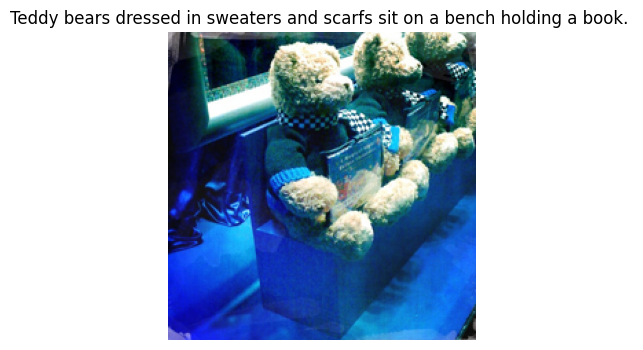

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def show_batch_example(b):
    img = b["pixel_values"][0].permute(1,2,0).numpy()
    img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    img = np.clip(img, 0, 1)
    plt.figure(figsize=(4,4))
    plt.imshow(img); plt.axis("off")
    plt.title(b["texts"][0])

show_batch_example(batch)


In [10]:
!pip install --quiet timm open_clip_torch


Step 7 — ViT encoder (patch tokens) + Transformer decoder (our captioner)

In [11]:
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision.models.vision_transformer import vit_b_16, VisionTransformer
from typing import Optional

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using device:", DEVICE)

# ---- ViT wrapper that returns patch tokens (not just a pooled vector) ----
class ViTEncoderTokens(nn.Module):
    """
    Wraps torchvision ViT-B/16 to return the full sequence of tokens after the encoder:
    shape: [B, 1 + P, D]  (class token + patch tokens)
    """
    def __init__(self, pretrained=True):
        super().__init__()
        self.vit: VisionTransformer = vit_b_16(weights="IMAGENET1K_V1" if pretrained else None)
        # freeze by default (we can unfreeze later)
        for p in self.vit.parameters():
            p.requires_grad = False
        self.embed_dim = self.vit.hidden_dim  # D

    def forward(self, x):
        # This mirrors torchvision VisionTransformer.forward, but we stop before the final norm/head
        B = x.shape[0]
        x = self.vit._process_input(x)                    # [B, P, D]
        n = x.shape[1]
        cls_token = self.vit.class_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)              # [B, 1+P, D]
        x = x + self.vit.encoder.pos_embedding[:, : (n + 1)]
        x = self.vit.encoder.dropout(x)
        x = self.vit.encoder.layers(x)                    # transformer blocks
        x = self.vit.encoder.ln(x)                        # final LN
        return x  # [B, 1+P, D]

# ---- Caption decoder: 6-layer Transformer decoder ----
class CaptionDecoder(nn.Module):
    def __init__(self, vocab_size, d_model=512, n_heads=8, n_layers=6, dropout=0.1, max_len=64, pad_id=0):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.pos_emb = nn.Embedding(max_len, d_model)
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=2048, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=n_layers)
        self.out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model
        self.max_len = max_len
        self.pad_id = pad_id

        # project ViT hidden to decoder dim if needed
        self.mem_proj = None

    def _causal_mask(self, L):
        # [L, L] True above diagonal
        mask = torch.triu(torch.ones(L, L, dtype=torch.bool), diagonal=1)
        return mask

    def forward(self, input_ids, attention_mask, memory_tokens):
        """
        input_ids: [B, L]
        attention_mask: [B, L] (1 for tokens, 0 for pad)
        memory_tokens: [B, M, Dv] (ViT tokens)
        """
        B, L = input_ids.shape
        pos = torch.arange(L, device=input_ids.device).unsqueeze(0)
        x = self.tok_emb(input_ids) + self.pos_emb(pos)
        x = self.dropout(x)

        mem = memory_tokens
        # project ViT tokens to decoder dim if dims mismatch
        if mem.shape[-1] != self.d_model:
            if self.mem_proj is None:
                self.mem_proj = nn.Linear(mem.shape[-1], self.d_model).to(mem.device)
            mem = self.mem_proj(mem)

        tgt_mask = self._causal_mask(L).to(input_ids.device)  # [L, L]
        # key padding masks: True where we want to mask (pads)
        tgt_key_padding = (attention_mask == 0)               # [B, L]
        # no mask for memory (we use all ViT tokens)
        out = self.decoder(tgt=x, memory=mem, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding)
        logits = self.out(out)  # [B, L, V]
        return logits

# ---- End-to-end model ----
class PixelParlanceModel(nn.Module):
    def __init__(self, vocab_size, pad_id, max_len=64, d_model=512):
        super().__init__()
        self.encoder = ViTEncoderTokens(pretrained=True)
        self.decoder = CaptionDecoder(vocab_size=vocab_size, d_model=d_model, n_heads=8, n_layers=6, dropout=0.1,
                                      max_len=max_len, pad_id=pad_id)

    def forward(self, pixel_values, input_ids, attention_mask):
        mem = self.encoder(pixel_values)                     # [B, 1+P, Dv]
        logits = self.decoder(input_ids, attention_mask, mem) # [B, L, V]
        return logits


Using device: cpu


Step 8 — Grounding regularizer (CLIP similarity) + loss & greedy decode

In [12]:
import open_clip
from transformers import AutoTokenizer

# Load a small CLIP for similarity (frozen)
clip_model, clip_preprocess, clip_tokenizer = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k', device=DEVICE)
for p in clip_model.parameters():
    p.requires_grad = False

def clip_image_text_cosine(images, texts):
    """
    images: [B, 3, H, W] *unnormalized for CLIP preprocess* (we'll re-preprocess from PIL if needed)
    texts:  list of strings length B
    Returns cosine similarities in [B]
    """
    # We already normalized images for ViT. For CLIP, we need its own preprocess.
    # Quick path: de-normalize back approximately and re-normalize for CLIP via its preprocess pipeline.
    # For simplicity in a notebook, we’ll re-run the preprocess from PIL; here we approximate by re-normalizing tensors.
    with torch.no_grad():
        # Safer: convert tensors back to CLIP expected norm
        # CLIP expects mean=(0.481, 0.457, 0.408), std=(0.268, 0.261, 0.275)
        mean = torch.tensor([0.485,0.456,0.406], device=images.device).view(1,3,1,1)
        std  = torch.tensor([0.229,0.224,0.225], device=images.device).view(1,3,1,1)
        img = images * std + mean

        # Re-normalize to CLIP stats
        mean_c = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=images.device).view(1,3,1,1)
        std_c  = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=images.device).view(1,3,1,1)
        img = (img - mean_c) / std_c
        img = torch.clamp(img, -10, 10)

        # Resize to CLIP's expected 224 if needed
        if img.shape[-1] != 224:
            img = F.interpolate(img, size=(224,224), mode="bicubic", align_corners=False)

        tok = open_clip.tokenize(texts).to(images.device)
        img_feat = clip_model.encode_image(img)
        txt_feat = clip_model.encode_text(tok)
        img_feat = F.normalize(img_feat, dim=-1)
        txt_feat = F.normalize(txt_feat, dim=-1)
        cos = (img_feat * txt_feat).sum(dim=-1)   # [B]
    return cos

# Loss helpers
def caption_loss(logits, labels, pad_id):
    # Cross-entropy with ignore index=-100 already set in labels
    return F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1), ignore_index=-100)

@torch.no_grad()
def greedy_decode(model, pixel_values, bos_id, eos_id, max_len=30):
    model.eval()
    B = pixel_values.size(0)
    mem = model.encoder(pixel_values)
    # start with BOS
    ids = torch.full((B,1), bos_id, dtype=torch.long, device=pixel_values.device)
    attn = torch.ones_like(ids)

    for _ in range(max_len-1):
        logits = model.decoder(ids, attn, mem)        # [B, L, V]
        next_id = logits[:, -1, :].argmax(-1, keepdim=True)  # [B, 1]
        ids = torch.cat([ids, next_id], dim=1)
        attn = torch.ones_like(ids)
        if ((ids[:,-1] == eos_id).all()):
            break
    return ids


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
d:\miniconda3\envs\sim\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Shurrab\.cache\huggingface\hub\models--laion--CLIP-ViT-B-32-laion2B-s34B-b79K. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this a

Step 9 — Wire training loop on the tiny split (quick sanity run)

In [13]:
# Reuse tokenizer from Phase 1
vocab_size = tokenizer.vocab_size
pad_id = tokenizer.pad_token_id
bos_id = tokenizer.bos_token_id if tokenizer.bos_token_id is not None else tokenizer.eos_token_id
eos_id = tokenizer.eos_token_id

model = PixelParlanceModel(vocab_size=vocab_size, pad_id=pad_id, max_len=MAX_LEN, d_model=512).to(DEVICE)

# Optim & schedule
optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=3e-4, weight_decay=0.01)
lambda_clip = 0.5  # grounding weight; feel free to adjust

def tensor_to_text(input_ids):
    return tokenizer.batch_decode(input_ids, skip_special_tokens=True)

def train_one_epoch(model, loader, epoch, print_every=100):
    model.train()
    total_ce, total_clip, total = 0.0, 0.0, 0
    for it, batch in enumerate(loader):
        images = batch["pixel_values"].to(DEVICE, non_blocking=True)
        input_ids = batch["input_ids"].to(DEVICE)
        attn_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        logits = model(images, input_ids, attn_mask)
        ce = caption_loss(logits, labels, pad_id)

        # greedy text for grounding (detach to keep stable)
        with torch.no_grad():
            pred_ids = greedy_decode(model, images, bos_id=bos_id, eos_id=eos_id, max_len=MAX_LEN)
            pred_texts = tensor_to_text(pred_ids)

        sims = clip_image_text_cosine(images, pred_texts)
        clip_loss = (1 - sims).mean()

        loss = ce + lambda_clip * clip_loss
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_ce += ce.item()
        total_clip += clip_loss.item()
        total += 1

        if (it+1) % print_every == 0:
            print(f"[epoch {epoch} iter {it+1}] CE={total_ce/total:.3f}  CLIP={total_clip/total:.3f}  total={ (total_ce + lambda_clip*total_clip)/total :.3f}")
    return total_ce/total, total_clip/total

# quick epoch on the tiny set
ce_avg, clip_avg = train_one_epoch(model, train_loader, epoch=1, print_every=50)
print("epoch done. avg CE:", round(ce_avg,3), "avg CLIP:", round(clip_avg,3))


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\Shurrab/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:06<00:00, 54.8MB/s] 


[epoch 1 iter 50] CE=5.088  CLIP=0.833  total=5.504
epoch done. avg CE: 4.541 avg CLIP: 0.833


Step 10 — Quick validation preview (greedy captions + grounding score)

In [14]:
@torch.no_grad()
def eval_preview(model, loader, n_batches=2):
    model.eval()
    for i, batch in enumerate(loader):
        images = batch["pixel_values"].to(DEVICE)
        ids = greedy_decode(model, images, bos_id=bos_id, eos_id=eos_id, max_len=MAX_LEN)
        texts = tokenizer.batch_decode(ids, skip_special_tokens=True)
        sims = clip_image_text_cosine(images, texts).cpu().tolist()
        for k in range(min(3, len(texts))):
            print(f"CAPTION: {texts[k]}")
            print(f"GROUNDING: {sims[k]:.3f}")
            print(f"GT: {batch['texts'][k]}\n")
        if i+1 >= n_batches:
            break

eval_preview(model, val_loader, n_batches=1)


CAPTION: PeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeoplePeople
GROUNDING: 0.129
GT: A clear glass bowl with bananas and plums in it. 

CAPTION: aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
GROUNDING: 0.178
GT: A large and green interstate exit sign above a road.

CAPTION: aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
GROUNDING: 0.194
GT: A row of attached buildings situated by a river.



Step 11 — Beam search (better decoding than greedy)

In [15]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def beam_search_decode(model, pixel_values, bos_id, eos_id, max_len=30, beam_size=5, length_penalty=0.7):
    """
    Returns a list[str] captions for the batch using beam search.
    length_penalty < 1.0 favors shorter, > 1.0 favors longer.
    """
    model.eval()
    B = pixel_values.size(0)
    mem = model.encoder(pixel_values)
    V = mem.shape[-1]

    # warm start with BOS
    beams = [{
        "ids": torch.full((1,1), bos_id, dtype=torch.long, device=pixel_values.device),  # [1, L]
        "logp": 0.0,
        "alive": True
    } for _ in range(B)]
    finished = [[] for _ in range(B)]

    # expand batch dimension for beams
    mem = mem.unsqueeze(1).expand(-1, beam_size, -1, -1).reshape(B*beam_size, -1, V)

    # initialize sequences
    seqs = torch.full((B*beam_size, 1), bos_id, dtype=torch.long, device=pixel_values.device)
    attn = torch.ones_like(seqs)

    beam_logp = torch.zeros(B, beam_size, device=pixel_values.device)
    beam_logp[:, 1:] = -1e9  # only first beam active at t=1

    for t in range(1, max_len):
        logits = model.decoder(seqs, attn, mem)  # [B*beam, L, Vocab]
        next_logit = logits[:, -1, :]
        log_probs = F.log_softmax(next_logit, dim=-1).view(B, beam_size, -1)  # [B, beam, V]

        # add previous beam scores
        scores = beam_logp.unsqueeze(-1) + log_probs  # [B, beam, V]
        scores = scores.view(B, -1)                   # [B, beam*V]

        topk_scores, topk_idx = torch.topk(scores, k=beam_size, dim=-1)

        next_beam = []
        next_seqs = []
        for b in range(B):
            beam_ids = (topk_idx[b] // next_logit.size(1)).tolist()  # which previous beam
            token_ids = (topk_idx[b] % next_logit.size(1)).tolist()  # which next token

            new_rows = []
            for k in range(beam_size):
                prev_beam = beam_ids[k]
                tok = token_ids[k]
                new_rows.append((prev_beam, tok, topk_scores[b, k].item()))
            next_beam.append(new_rows)

        # build new seqs
        new_seqs = []
        new_logp = torch.zeros_like(beam_logp)
        ended_mask = torch.zeros(B, beam_size, dtype=torch.bool, device=pixel_values.device)
        for b in range(B):
            rows = []
            for k,(prev_beam, tok, score) in enumerate(next_beam[b]):
                prev_seq = seqs[b*beam_size + prev_beam]
                new_seq = torch.cat([prev_seq, torch.tensor([tok], device=seqs.device)], dim=0)
                new_seqs.append(new_seq)
                new_logp[b, k] = score
                if tok == eos_id:
                    # length-normalized score
                    ln = (len(new_seq) ** length_penalty)
                    finished[b].append((score/ln, new_seq.clone()))
                    ended_mask[b, k] = True
        seqs = torch.nn.utils.rnn.pad_sequence(new_seqs, batch_first=True, padding_value=bos_id)
        attn = torch.ones_like(seqs)
        beam_logp = new_logp

        if ended_mask.all():
            break

    # pick best finished or fall back to best alive
    outputs = []
    for b in range(B):
        if finished[b]:
            best = max(finished[b], key=lambda x: x[0])[1]
        else:
            # take best current
            k = int(torch.argmax(beam_logp[b]).item())
            best = seqs[b*beam_size + k]
        outputs.append(best)
    return outputs


In [16]:
@torch.no_grad()
def preview_with_beam(model, loader, n_batches=1):
    for i, batch in enumerate(loader):
        images = batch["pixel_values"].to(DEVICE)
        out_ids = beam_search_decode(model, images, bos_id, eos_id, max_len=40, beam_size=5, length_penalty=0.8)
        texts = tokenizer.batch_decode(out_ids, skip_special_tokens=True)
        for k in range(min(3, len(texts))):
            print("CAPTION:", texts[k])
            print("GT     :", batch["texts"][k], "\n")
        break

preview_with_beam(model, val_loader)


CAPTION: aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
GT     : A clear glass bowl with bananas and plums in it.  

CAPTION: aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
GT     : A large and green interstate exit sign above a road. 

CAPTION: aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
GT     : A row of attached buildings situated by a river. 



Step 12 — Save predictions on (tiny) val for metrics

In [17]:
import pandas as pd

def generate_preds_csv(model, loader, out_csv="preds_tiny_val.csv", use_beam=True):
    rows = []
    for batch in loader:
        images = batch["pixel_values"].to(DEVICE)
        if use_beam:
            ids = beam_search_decode(model, images, bos_id, eos_id, max_len=40, beam_size=5, length_penalty=0.8)
        else:
            ids = greedy_decode(model, images, bos_id, eos_id, max_len=40)
        caps = tokenizer.batch_decode(ids, skip_special_tokens=True)
        for p, c, gt in zip(batch["texts"], caps, batch["texts"]):
            rows.append({"image_path": p, "caption_pred": c, "caption_gt": gt})
    pd.DataFrame(rows).to_csv(out_csv, index=False)
    print("Saved →", out_csv)

generate_preds_csv(model, val_loader, out_csv="preds_tiny_val.csv", use_beam=True)


Saved → preds_tiny_val.csv


Step 13 — COCO-style text metrics (BLEU, METEOR, ROUGE-L, CIDEr, SPICE)

In [18]:
!pip install --quiet sacrebleu nltk rouge-score
import sacrebleu, nltk
nltk.download('wordnet', quiet=True)
from rouge_score import rouge_scorer
import pandas as pd
import numpy as np

def compute_text_metrics(pred_csv):
    df = pd.read_csv(pred_csv)
    hyps = [str(x) for x in df["caption_pred"].tolist()]
    refs = [[str(x)] for x in df["caption_gt"].tolist()]  # one ref per image (tiny set)
    
    bleu = sacrebleu.corpus_bleu(hyps, list(zip(*refs))).score
    chrf = sacrebleu.corpus_chrf(hyps, list(zip(*refs))).score

    # ROUGE-L average
    rs = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rougeL = np.mean([rs.score(r[0], h)['rougeL'].fmeasure for h,r in zip(hyps, refs)])
    
    # METEOR (nltk)
    from nltk.translate.meteor_score import meteor_score
    meteor = np.mean([meteor_score(r, h) for h,r in zip(hyps, refs)])

    print(f"BLEU:   {bleu:.2f}")
    print(f"METEOR: {meteor:.3f}")
    print(f"ROUGE-L:{rougeL:.3f}")
    print(f"chrF++: {chrf:.2f}")
    return {"BLEU":bleu, "METEOR":meteor, "ROUGE-L":rougeL, "chrF++":chrf}

_ = compute_text_metrics("preds_tiny_val.csv")


  DEPRECATION: Building 'rouge-score' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'rouge-score'. Discussion can be found at https://github.com/pypa/pip/issues/6334


TypeError: "hypothesis" expects pre-tokenized hypothesis (Iterable[str]): aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

Step 14 — CLIPScore (grounding proxy, fully automatic)

In [ ]:
import pandas as pd
import torch

def compute_clipscore(pred_csv):
    df = pd.read_csv(pred_csv)
    scores = []
    for i in range(0, len(df), 32):
        chunk = df.iloc[i:i+32]
        # load images from disk
        imgs = []
        for p in chunk["image_path"]:
            im = Image.open(p).convert("RGB")
            # CLIP preprocess to tensor
            t = clip_preprocess(im).unsqueeze(0)
            imgs.append(t)
        imgs = torch.cat(imgs, 0).to(DEVICE)
        txt = chunk["caption_pred"].tolist()
        with torch.no_grad():
            img_feat = clip_model.encode_image(imgs)
            txt_tok = open_clip.tokenize(txt).to(DEVICE)
            txt_feat = clip_model.encode_text(txt_tok)
            img_feat = F.normalize(img_feat, dim=-1)
            txt_feat = F.normalize(txt_feat, dim=-1)
            cos = (img_feat * txt_feat).sum(dim=-1).detach().cpu().tolist()
            scores.extend(cos)
    s = np.array(scores)
    print(f"CLIPScore — mean: {s.mean():.3f} | median: {np.median(s):.3f}")
    return s

_ = compute_clipscore("preds_tiny_val.csv")


Step 15 — CHAIR-style hallucination (GT-based, automatic)

In [ ]:
import json, re
from collections import defaultdict
import pandas as pd
from pathlib import Path

# Load COCO instances (val)
with open(ANN_DIR / "instances_val2017.json", "r") as f:
    inst = json.load(f)
cat_id_to_name = {c["id"]: c["name"] for c in inst["categories"]}
img_id_to_objs = defaultdict(set)
for a in inst["annotations"]:
    img_id_to_objs[a["image_id"]].add(cat_id_to_name[a["category_id"]])
filename_to_id = {im["file_name"]: im["id"] for im in inst["images"]}

# Synonyms (starter map)
COCO_SYNONYMS = {
    "person":{"person","man","woman","boy","girl","people","guy","lady"},
    "bicycle":{"bicycle","bike"},
    "car":{"car","auto","automobile","sedan"},
    "motorcycle":{"motorcycle","motorbike","bike"},
    "airplane":{"airplane","plane","jet","aircraft"},
    "bus":{"bus","coach"},
    "train":{"train"},
    "truck":{"truck","lorry"},
    "boat":{"boat","ship"},
    "traffic light":{"traffic light","stoplight"},
    "fire hydrant":{"fire hydrant","hydrant"},
    "stop sign":{"stop sign"},
    "parking meter":{"parking meter"},
    "bench":{"bench"},
    "bird":{"bird"},
    "cat":{"cat","kitty"},
    "dog":{"dog","puppy"},
    "horse":{"horse"},
    "sheep":{"sheep","lamb"},
    "cow":{"cow","cattle"},
    "elephant":{"elephant"},
    "bear":{"bear"},
    "zebra":{"zebra"},
    "giraffe":{"giraffe"},
    "backpack":{"backpack","bagpack"},
    "umbrella":{"umbrella"},
    "handbag":{"handbag","purse","bag"},
    "tie":{"tie","necktie"},
    "suitcase":{"suitcase","luggage"},
    "frisbee":{"frisbee","disc"},
    "skis":{"ski","skis"},
    "snowboard":{"snowboard"},
    "sports ball":{"ball","soccer ball","basketball","football","tennis ball"},
    "kite":{"kite"},
    "baseball bat":{"baseball bat","bat"},
    "baseball glove":{"baseball glove","mitt","glove"},
    "skateboard":{"skateboard"},
    "surfboard":{"surfboard"},
    "tennis racket":{"tennis racket","racket","racquet"},
    "bottle":{"bottle"},
    "wine glass":{"wine glass"},
    "cup":{"cup","mug"},
    "fork":{"fork"},
    "knife":{"knife"},
    "spoon":{"spoon"},
    "bowl":{"bowl"},
    "banana":{"banana"},
    "apple":{"apple"},
    "sandwich":{"sandwich"},
    "orange":{"orange"},
    "broccoli":{"broccoli"},
    "carrot":{"carrot"},
    "hot dog":{"hot dog"},
    "pizza":{"pizza","slice"},
    "donut":{"donut","doughnut"},
    "cake":{"cake"},
    "chair":{"chair","seat"},
    "couch":{"couch","sofa"},
    "potted plant":{"potted plant","plant"},
    "bed":{"bed"},
    "dining table":{"dining table","table"},
    "toilet":{"toilet","wc","restroom"},
    "tv":{"tv","television","monitor","screen"},
    "laptop":{"laptop","notebook"},
    "mouse":{"mouse"},
    "remote":{"remote","remote control"},
    "keyboard":{"keyboard"},
    "cell phone":{"cell phone","phone","mobile","smartphone"},
    "microwave":{"microwave"},
    "oven":{"oven","stove"},
    "toaster":{"toaster"},
    "sink":{"sink"},
    "refrigerator":{"refrigerator","fridge"},
    "book":{"book"},
    "clock":{"clock"},
    "vase":{"vase"},
    "scissors":{"scissors"},
    "teddy bear":{"teddy bear","teddy"},
    "hair drier":{"hair drier","hair dryer"},
    "toothbrush":{"toothbrush"},
}

def caption_objects(caption:str):
    cap = " " + re.sub(r"[^a-z0-9 ]"," ", caption.lower()) + " "
    preds = set()
    for canon, syns in COCO_SYNONYMS.items():
        for s in sorted(syns, key=len, reverse=True):
            if f" {s} " in cap:
                preds.add(canon); break
    return preds

def file_to_image_id(p):
    name = Path(p).name
    if name in filename_to_id:
        return filename_to_id[name]
    m = re.search(r"(\d+)\.jpg$", name)
    return int(m.group(1)) if m else None

def chair_metrics(pred_csv):
    df = pd.read_csv(pred_csv)
    total_mentions = total_hallu = sent_hallu = 0
    for _, r in df.iterrows():
        img_id = file_to_image_id(r["image_path"])
        if img_id is None or img_id not in img_id_to_objs:
            continue
        gt = img_id_to_objs[img_id]
        pred_objs = caption_objects(str(r["caption_pred"]))
        hallu = pred_objs - gt
        total_mentions += len(pred_objs)
        total_hallu += len(hallu)
        sent_hallu += int(len(hallu) > 0)
    N = len(df)
    CHAIRs = sent_hallu / max(N, 1)
    CHAIRi = total_hallu / max(total_mentions, 1) if total_mentions else 0.0
    print(f"CHAIRs (fraction of captions with any hallucination): {CHAIRs:.3f}")
    print(f"CHAIRi (fraction of mentioned objects hallucinated): {CHAIRi:.3f}")
    return CHAIRs, CHAIRi

_ = chair_metrics("preds_tiny_val.csv")


Step 16 — Detector-backed consistency (small sample)

In [ ]:
!pip install --quiet torchvision
import torchvision
from torchvision.ops import nms
import torch
import pandas as pd
from PIL import Image

detector = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT").to(DEVICE).eval()
COCO_LABELS = detector.transform.box_coder  # placeholder; we need actual label map:
# Torchvision's detector uses 91-class mapping; we’ll load a standard list:
COCO91 = [
    "__bg__", "person","bicycle","car","motorcycle","airplane","bus","train","truck","boat",
    "traffic light","fire hydrant","__","stop sign","parking meter","bench","bird","cat","dog","horse",
    "sheep","cow","elephant","bear","zebra","giraffe","__","backpack","umbrella","__","__","handbag",
    "tie","suitcase","frisbee","skis","snowboard","sports ball","kite","baseball bat","baseball glove",
    "skateboard","surfboard","tennis racket","bottle","__","wine glass","cup","fork","knife","spoon","bowl",
    "banana","apple","sandwich","orange","broccoli","carrot","hot dog","pizza","donut","cake","chair","couch",
    "potted plant","bed","__","dining table","__","__","toilet","__","tv","laptop","mouse","remote","keyboard",
    "cell phone","microwave","oven","toaster","sink","refrigerator","__","book","clock","vase","scissors","teddy bear",
    "hair drier","toothbrush"
]

def detector_consistency(pred_csv, max_images=100, conf=0.5):
    df = pd.read_csv(pred_csv).head(max_images)
    ok, total_mentions = 0, 0
    for _, r in df.iterrows():
        im = Image.open(r["image_path"]).convert("RGB")
        x = torchvision.transforms.functional.pil_to_tensor(im).float()/255.0
        x = torchvision.transforms.functional.resize(x, [800])
        with torch.no_grad():
            out = detector([x.to(DEVICE)])[0]
        keep = out["scores"] >= conf
        labels = [COCO91[l] for l in out["labels"][keep].tolist() if l < len(COCO91)]
        det_set = set(labels)
        pred_objs = caption_objects(str(r["caption_pred"]))
        # count how many mentioned objects are detected
        total_mentions += len(pred_objs)
        ok += sum(1 for o in pred_objs if o in det_set)
    prec = ok / max(total_mentions,1)
    print(f"Detector precision of mentioned objects (top-{max_images} imgs): {prec:.3f}")
    return prec

# detector_consistency("preds_tiny_val.csv", max_images=50, conf=0.6)
